# Estimate the ending position

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


# Generate all validation scripts
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

## 1. Load a trained model

In [2]:
# Hide warning to make the notebook clear.
import warnings
#warnings.filterwarnings('ignore')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#### Import libraries and setup matplotlib

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from data_utils import TextMelLoader
from model import Tacotron2
from layers import TacotronSTFT, STFT
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [5]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [6]:
for s in "batch_size=32,txt_type=p_g2p,all_dbs=[bc2013],dbs=[bc2013],all_emotions=[neutral],emotions=[neutral],all_speakers=[bc2013-w],speakers=[bc2013-w],distributed_run=True,dist_port=54322,lr_scheduling=True".split(','):
    print(s)

batch_size=32
txt_type=p_g2p
all_dbs=[bc2013]
dbs=[bc2013]
all_emotions=[neutral]
emotions=[neutral]
all_speakers=[bc2013-w]
speakers=[bc2013-w]
distributed_run=True
dist_port=54322
lr_scheduling=True


In [7]:
'''
batch_size=32
txt_type=p_g2p
all_dbs=[bc2013]
dbs=[bc2013]
all_emotions=[neutral]
emotions=[neutral]
all_speakers=[bc2013-w]
speakers=[bc2013-w]
distributed_run=True
dist_port=54322
lr_scheduling=True
'''
hparams = create_hparams()
hparams.batch_size=32
hparams.txt_type='p_g2p'
hparams.all_dbs=['bc2013']
hparams.all_speakers=['bc2013-w']
hparams.all_emotions=['neutral']
hparams.dbs=['bc2013']
hparams.speakers=['bc2013-w']
hparams.emotions=['neutral']

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [8]:
#checkpoint_path = "tacotron2_statedict.pt"
#checkpoint_path = "outdir/checkpoint_24000"
prj_name = 'bc2013'
run_name = 'pretrain_g2p_2gpus_v7_db_v2'
checkpoint_name = 'checkpoint_57574-epoch_47.0_end-epoch_47'
checkpoint_path = "outdir/{}/{}/{}".format(prj_name, run_name, checkpoint_name)
#checkpoint_path = '/home/sungjaecho/pretrained/tacotron2_statedict.pt'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [9]:
#waveglow_path = 'waveglow_256channels.pt'
waveglow_path = '/data2/sungjaecho/pretrained/waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

## 2. Generate all validation scripts

### 2.1. Generate audios one by one

#### 2.1.1. Functionalize the generating process

In [10]:
import matplotlib.pylab as plt
import soundfile as sf
from measures import forward_attention_ratio, attention_ratio, attention_range_ratio, multiple_attention_ratio
from text import text_to_sequence, sequence_to_text, sequence_to_text_list

def synthesize_speech(text, str_speaker, str_emotion):
    # Prepare a text input.
    val_set = TextMelLoader(hparams, 'val')
    text = ' ' + text + ' '
    sequence = np.array(text_to_sequence(text, 
                                         hparams.text_cleaners, 
                                         hparams.txt_type, 
                                         val_set.get_g2p_dictionary()))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()

    speaker_index = val_set.get_speaker(str_speaker).long().cuda()
    emotion_vector = val_set.get_emotion_input(str_emotion).half().cuda().view(1,-1)
    
    mel_outputs, mel_outputs_postnet, gate_outputs, alignments, _, _ = model.inference(sequence, speaker_index, emotion_vector)
    
    alignments = alignments.squeeze(dim=2)
    
    input_lengths = torch.Tensor([sequence.size(1)]).long().cuda()
    far, _ = forward_attention_ratio(alignments, input_lengths, gate_outputs=gate_outputs, mode_mel_length="stop_token")
    ar_tuple = attention_ratio(alignments, input_lengths, sequence, gate_outputs=gate_outputs, mode_mel_length="stop_token")
    ar = ar_tuple[0][0]
    arr, _ = attention_range_ratio(alignments, input_lengths, gate_outputs=gate_outputs, mode_mel_length="stop_token")
    mar, _ = multiple_attention_ratio(alignments, input_lengths, sequence, gate_outputs=gate_outputs, mode_mel_length="stop_token", enc_element='letter')
    att_quality = far * ar * arr * (1 - mar)

    
    print("Speaker: {}".format(str_speaker))
    print("Emotion: {}".format(str_emotion))
    print("Text     : {}".format(text))
    print("Text used: {}".format(sequence_to_text(sequence.squeeze().cpu().tolist())))
    print("Attention quality:        {:.4f}".format(att_quality))
    print("Forward attentoin ratio:  {:.4f}".format(far))
    print("Attentoin ratio:          {:.4f}".format(ar))
    print("Range attentoin ratio:    {:.4f}".format(arr))
    print("Multiple attentoin ratio: {:.4f}".format(mar))
    
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    plt.show()
    
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=1)
        #audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
        
    np_audio = audio[0].data.cpu().numpy()
    sample_rate = hparams.sampling_rate
    text_list = sequence_to_text_list(sequence.squeeze().cpu().tolist())
    return np_audio, sample_rate, sequence, text_list, alignments, att_quality


def make_wav_dir(prj_name, run_name, checkpoint_name):
    top_dir = 'inference_ipynb'
    
    wav_dir = os.path.join(top_dir, prj_name)
    if not os.path.exists(wav_dir):
        os.mkdir(wav_dir)
    
    wav_dir = os.path.join(top_dir, prj_name, run_name)
    if not os.path.exists(wav_dir):
        os.mkdir(wav_dir)
    
    wav_dir = os.path.join(top_dir, prj_name, run_name, checkpoint_name)
    if not os.path.exists(wav_dir):
        os.mkdir(wav_dir)
        
    return wav_dir


def slugify(text):
    """
    From: https://stackoverflow.com/questions/295135/turn-a-string-into-a-valid-filename
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    import string
    valid_chars = "-_() %s%s" % (string.ascii_letters, string.digits)

    text = ''.join(c for c in text if c in valid_chars)
    
    return text

#### 2.1.2. Generate audios one by one: For all validation samples

In [11]:
from utils import load_wavpath_text_speaker_sex_emotion_lang

In [12]:
valsets = dict()

In [13]:
for speaker in hparams.speakers:
    for emotion in hparams.emotions:
        valsets[(speaker, emotion)] = load_wavpath_text_speaker_sex_emotion_lang(hparams, 'val', speaker, emotion, 0)[0]
        print("len(valsets[({speaker}, {emotion})]) = {length}".format(
            speaker=speaker,
            emotion=emotion,
            length=len(valsets[(speaker, emotion)])
        ))

len(valsets[(bc2013-w, neutral)]) = 100


Stopped by 1st ending predictor
Speaker: bc2013-w
Emotion: neutral
Text     :  The visit was soon returned in due form. 
Text used:  {DH AH0} {V IH1 Z AH0 T} {W AA1 Z} {S UW1 N} {R IH0 T ER1 N D} {IH0 N} {D UW1} {F AO1 R M} . 
Attention quality:        0.9788
Forward attentoin ratio:  0.9788
Attentoin ratio:          1.0000
Range attentoin ratio:    1.0000
Multiple attentoin ratio: 0.0000


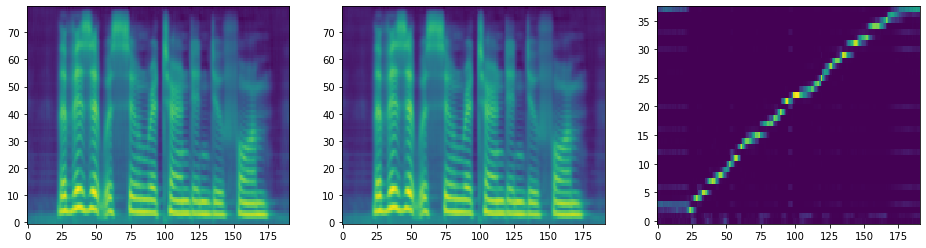

In [14]:
script = "The visit was soon returned in due form."
speaker = 'bc2013-w'
emotion = 'neutral'
np_audio, sample_rate, sequence, text_list, alignments, aq = synthesize_speech(script, speaker, emotion)
ipd.display(ipd.Audio(np_audio, rate=hparams.sampling_rate))

Stopped by 1st ending predictor
Speaker: bc2013-w
Emotion: neutral
Text     :  The visit was soon returned in due form. 
Text used:  {DH AH0} {V IH1 Z AH0 T} {W AA1 Z} {S UW1 N} {R IH0 T ER1 N D} {IH0 N} {D UW1} {F AO1 R M} . 
Attention quality:        0.9735
Forward attentoin ratio:  0.9735
Attentoin ratio:          1.0000
Range attentoin ratio:    1.0000
Multiple attentoin ratio: 0.0000


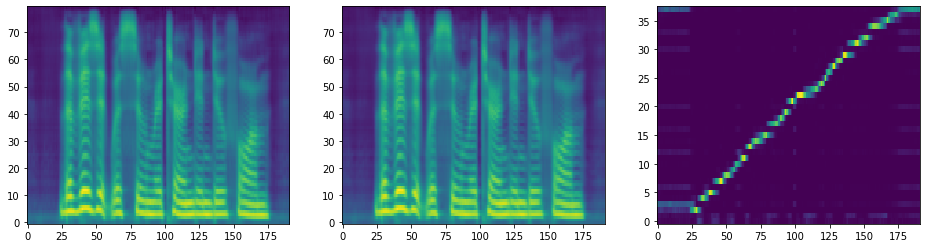

In [15]:
script = "The visit was soon returned in due form."
speaker = 'bc2013-w'
emotion = 'neutral'
np_audio, sample_rate, sequence, text_list, alignments, aq = synthesize_speech(script, speaker, emotion)
ipd.display(ipd.Audio(np_audio, rate=hparams.sampling_rate))

Stopped by self.backward_steps[i] > self.prev_backward_steps[i]
Speaker: bc2013-w
Emotion: neutral
Text     :  A light flapped over the scene, as if reflected from phosphorescent wings crossing the sky, and a rumble filled the air??? 
Text used:  {AH0} {L AY1 T} {F L AE1 P T} {OW1 V ER0} {DH AH0} {S IY1 N} , {AE1 Z} {IH1 F} {R AH0 F L EH1 K T AH0 D} {F R AH1 M} {F AA1 S F ER0 AH0 S AH0 N T S} {W IH1 NG Z} {K R AO1 S IH0 NG} {DH AH0} {S K AY1} , {AH0 N D} {AH0} {R AH1 M B AH0 L} {F IH1 L D} {DH AH0} {EH1 R} ? ? ? 
Attention quality:        0.9566
Forward attentoin ratio:  0.9908
Attentoin ratio:          0.9909
Range attentoin ratio:    1.0000
Multiple attentoin ratio: 0.0256


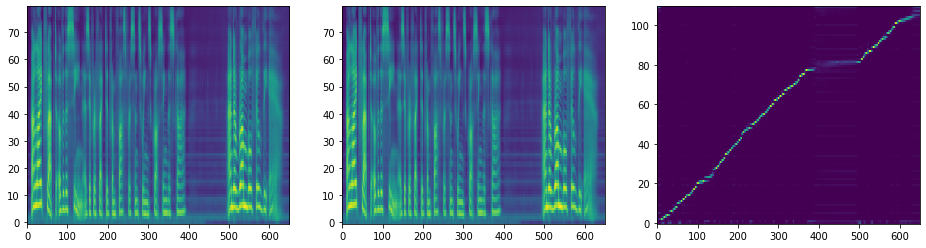

In [21]:
script = "A light flapped over the scene, as if reflected from phosphorescent wings crossing the sky, and a rumble filled the air???"
speaker = 'bc2013-w'
emotion = 'neutral'
np_audio, sample_rate, sequence, text_list, alignments, aq = synthesize_speech(script, speaker, emotion)
ipd.display(ipd.Audio(np_audio, rate=hparams.sampling_rate))

In [17]:
ipd.display(ipd.Audio(np_audio, rate=hparams.sampling_rate))

In [40]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

from text import sequence_to_text
from text.find_symbol_location import find_letter_locations, find_punctuation_locations, find_blank_locations

class SecondStopPredictor():
    def __init__(self, max_decoder_steps, letter_att_top_k=5):
        self.max_decoder_steps = max_decoder_steps
        self.letter_att_top_k = letter_att_top_k
        self.stop_dec_steps_after_lar_1 = 20
        self.stop_same_forward_steps = 10 # 10 * 

    def initialize(self, text_padded, input_lengths):
        '''
        Params
        -----
        text_padded: torch.LongTensor. Shape: [batch_size, max_batch_input_len].
        input_lengths: torch.Tenor. A 1-D tensor that keeps input text lengths. Shape: [batch_size].
        '''
        self.text_padded = text_padded.detach().cpu()
        self.batch_size = text_padded.size(0)
        self.max_input_length = text_padded.size(1)
        self.input_lengths = input_lengths.detach().cpu()
        self.dec_step = -1
        self.forward_steps = torch.zeros((self.batch_size))
        self.prev_forward_steps = torch.zeros((self.batch_size))
        self.prev_argmax_att_w = torch.zeros((self.batch_size))
        self.prev_attention_weights = torch.zeros(
            (self.batch_size, self.max_input_length))
        self.prev_letters_top_k_att_w = list()
        self.multiple_att_letter_sets = list()
        self.att_letter_sets = list()
        self.letter_locations = list()
        self.max_aq = torch.zeros((self.batch_size))
        self.cnt_dec_steps_after_lar_1 = torch.zeros((self.batch_size))
        self.cnt_same_argmax_att = torch.zeros((self.batch_size))
        self.end_points = [self.max_decoder_steps] * self.batch_size
        self.end_found = [False] * self.batch_size
        self.forward_attention_ratio = torch.zeros((self.batch_size))
        self.letter_attention_ratio = torch.zeros((self.batch_size))
        self.multiple_attention_ratio = torch.zeros((self.batch_size))
        
        self.starting_cnt_same_argmax_att = -1

        for i in range(self.batch_size):
            text_length = input_lengths[i].item()
            text_sequence = text_padded[i,:text_length].view(1, -1)
            text_sequence_list = text_sequence.squeeze().tolist()
            self.prev_letters_top_k_att_w.append(set())
            self.multiple_att_letter_sets.append(set())
            self.att_letter_sets.append(set())
            self.letter_locations.append(set(find_letter_locations(text_sequence_list)))


    def get_attention_measures(self):
        return self.forward_attention_ratio, self.letter_attention_ratio, self.multiple_attention_ratio

    def get_end_points(self):
        return self.end_points

    def predict(self, attention_weights):
        '''
        Params
        -----
        attention_weights: Attention map.
        - Type: torch.Tensor.
        - Shape: [batch_size, max_batch_txt_steps].

        Returns
        -----
        end_decoding: Whether to end the decoding loop.
        - Type: bool.
        - If True, then end the decoding loop. Otherwise, keep the loop.
        end_points
        - Type: list. Element type: int.
        - Length: batch_size.
        '''
        self.dec_step += 1
        attention_weights = attention_weights.detach().cpu()
        forward_attention_ratio = torch.zeros((self.batch_size))
        letter_attention_ratio = torch.zeros((self.batch_size))

        for i in range(self.batch_size):
            '''if self.end_found[i]:
                continue'''
            text_length = self.input_lengths[i]
            attention_weight = attention_weights[i,:text_length]

            #arg_top_k_att_w = torch.argsort(attention_weight, descending=True)[:self.letter_att_top_k].tolist()
            arg_top_k_att_w = torch.topk(attention_weight, self.letter_att_top_k)[1].tolist()
            #argmax_att_w = torch.argmax(attention_weight)
            argmax_att_w = arg_top_k_att_w[0]

            letters_top_k_att_w = self.letter_locations[i].intersection(arg_top_k_att_w)

            if self.dec_step > 0:
                if argmax_att_w >= self.prev_argmax_att_w[i]:
                    self.forward_steps[i] += 1
                forward_attention_ratio[i] = self.forward_steps[i] / self.dec_step

                prev_letters_top_k_att_w = self.prev_letters_top_k_att_w[i]
                prev_att_letter_set = self.att_letter_sets[i]

                '''self.multiple_att_letter_sets[i] = self.multiple_att_letter_sets[i].union(
                    letters_top_k_att_w.difference(
                        prev_letters_top_k_att_w).intersection(
                            prev_att_letter_set))

                multiple_attention_ratio[i] = len(self.multiple_att_letter_sets[i]) / len(self.letter_locations[i])'''


            self.att_letter_sets[i] = self.att_letter_sets[i].union(letters_top_k_att_w)
            letter_attention_ratio[i] = len(self.att_letter_sets[i]) / len(self.letter_locations[i])

            # Attention quality
            '''aq = get_attention_quality(
                forward_attention_ratio[i],
                multiple_attention_ratio[i],
                letter_attention_ratio[i])'''
            aq = forward_attention_ratio[i] * letter_attention_ratio[i]

            # Record max attention quality
            pre_max_aq = self.max_aq[i]
            if aq > self.max_aq[i]:
                self.max_aq[i] = aq

            if (argmax_att_w == self.prev_argmax_att_w[i]) and \
                letter_attention_ratio[i] == 1.0 and not self.end_found[i]:
                if  self.cnt_same_argmax_att[i] == 0:
                    self.starting_cnt_same_argmax_att = self.dec_step
                self.cnt_same_argmax_att[i] += 1
            else:
                 self.cnt_same_argmax_att[i] = 0

            # Determine the end points of the given batch samples.
            # End point: The end of speech. This should not included in speech.
            # - speech[:self.end_points[i]] is the right range for slicing.
            if (letter_attention_ratio[i] == 1.0 and not self.end_found[i]) \
                and (self.max_aq[i] > aq):
                print(letter_attention_ratio[i])
                print(self.dec_step)
                
            if (letter_attention_ratio[i] == 1.0 and not self.end_found[i]) \
                and (self.cnt_same_argmax_att[i] > self.stop_same_forward_steps \
                    or self.max_aq[i] > aq):
                # If an enpoint is found, ...
                if self.cnt_same_argmax_att[i] > self.stop_same_forward_steps:
                    print("Stopped by self.cnt_same_argmax_att[i] > self.stop_same_forward_steps")
                if self.max_aq[i] > aq:
                    print("Stopped by self.max_aq[i] > aq")
                self.end_points[i] = self.dec_step
                self.end_found[i] = True
 
            # If an endpoint is not found, ...
            self.forward_attention_ratio[i] = forward_attention_ratio[i]
            self.letter_attention_ratio[i] = letter_attention_ratio[i]
            '''self.multiple_attention_ratio[i] = multiple_attention_ratio[i]'''

                
            self.prev_forward_steps[i] = self.forward_steps[i]
            self.prev_argmax_att_w[i] = argmax_att_w
            self.prev_attention_weights[i,:text_length] = attention_weight
            self.prev_letters_top_k_att_w[i] = letters_top_k_att_w

        end_decoding = True if sum(self.end_found) == self.batch_size else False
        end_points = self.end_points
        aq = forward_attention_ratio * letter_attention_ratio

        return end_decoding, end_points, self.starting_cnt_same_argmax_att, self.forward_attention_ratio.clone(), self.letter_attention_ratio.clone(), self.multiple_attention_ratio.clone(), aq

In [21]:
stop_predictor2 = SecondStopPredictor(1000)

In [22]:
input_lengths = torch.Tensor([sequence.size(1)]).long().cuda()

In [23]:
alignments.size()

torch.Size([1, 1000, 56])

In [24]:
torch.argmax(alignments,dim=2)

tensor([[ 3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  4,  4,
          4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
          7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
         17, 17, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21,
         21, 22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26,
         26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29,
         29, 29, 29, 29, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 35, 35, 35,
         35, 35, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39,
         39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 42, 44, 44,
         44, 44, 44, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 49, 49, 49,
         49, 49, 49, 50, 50,

In [25]:
tensor_far_list = list()
tensor_lar_list = list()
tensor_mar_list = list()
tensor_aq_list = list()
stop_predictor2.initialize(sequence, input_lengths)
for i in range(alignments.size(1)):
    attention_weights = alignments[:,i,:]
    end_decoding, end_points, starting_cnt_same_argmax_att, far, lar, mar, aq = stop_predictor2.predict(attention_weights.float())
    tensor_far_list.append(far)
    tensor_lar_list.append(lar)
    tensor_mar_list.append(mar)
    tensor_aq_list.append(aq)

Stopped by self.cnt_same_argmax_att[i] > self.stop_same_forward_steps


In [26]:
tensor_far = torch.stack(tensor_far_list).transpose(1,0)
tensor_lar = torch.stack(tensor_lar_list).transpose(1,0)
tensor_mar = torch.stack(tensor_mar_list).transpose(1,0)
tensor_aq = torch.stack(tensor_aq_list).transpose(1,0)

In [27]:
end_points, tensor_far.size(), tensor_lar.size(), tensor_mar.size(), tensor_aq.size(), 

([264],
 torch.Size([1, 1000]),
 torch.Size([1, 1000]),
 torch.Size([1, 1000]),
 torch.Size([1, 1000]))

264
torch.Size([1, 1000])


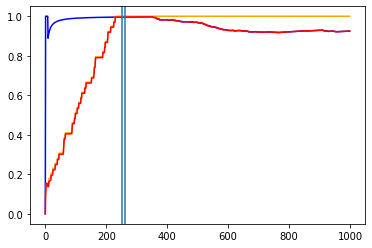

In [28]:
plt.plot(tensor_far[0,:], 'blue')
plt.plot(tensor_lar[0,:], 'orange')
#plt.plot(tensor_mar[0,:], 'green')
plt.plot(tensor_aq[0,:], 'red')
end_point = end_points[0]
print(end_point)
print(tensor_aq.size())
plt.axvline(starting_cnt_same_argmax_att-1)
plt.axvline(end_point-1)
np_end_point = int(end_point / tensor_aq.size(1) * np_audio.shape[0])
ipd.display(ipd.Audio(np_audio[:np_end_point+1], rate=hparams.sampling_rate))
plt.show()

264
torch.Size([1, 1000])


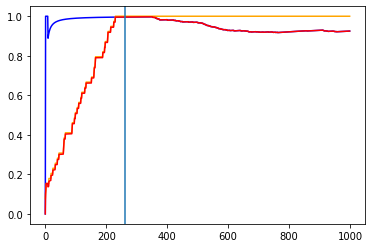

In [29]:
plt.plot(tensor_far[0,:], 'blue')
plt.plot(tensor_lar[0,:], 'orange')
#plt.plot(tensor_mar[0,:], 'green')
plt.plot(tensor_aq[0,:], 'red')
end_point = end_points[0]
print(end_point)
print(tensor_aq.size())
plt.axvline(end_point-1)
np_end_point = int(end_point / tensor_aq.size(1) * np_audio.shape[0])
ipd.display(ipd.Audio(np_audio[:np_end_point+1], rate=hparams.sampling_rate))
plt.show()

In [487]:
tensor_lar[0,480]

tensor(1.)

In [488]:
stop_predictor2.letter_locations[0].difference(stop_predictor2.att_letter_sets[0])

set()

In [489]:
from g2p_en import G2p
from text import _clean_text
g2p = G2p()
text = script
clean_text = _clean_text(text, hparams.text_cleaners)
p_symbols_list = g2p(text)
p_symbols_list = [' '] + p_symbols_list + [' ']

In [490]:
print(p_symbols_list[23])
print(p_symbols_list[23-10:23+10])

print(p_symbols_list[43])
print(p_symbols_list[43-10:43+10])

EH1
['N', 'D', ' ', 'B', 'EH1', 'T', 'ER0', ' ', 'F', 'R', 'EH1', 'N', 'D', 'Z', ' ', 'DH', 'AE1', 'N', ' ', ',']
Y
[' ', 'P', 'ER0', 'HH', 'AE1', 'P', 'S', ' ', ',', ' ', 'Y', 'UW1', ' ', 'S', 'AH0', 'S', 'P', 'EH1', 'K', 'T']


Text     :  We are older and better friends than, perhaps, you suspect. 
Text used:  {W IY1} {AA1 R} {OW1 L D ER0} {AH0 N D} {B EH1 T ER0} {F R EH1 N D Z} {DH AE1 N} , {P ER0 HH AE1 P S} , {Y UW1} {S AH0 S P EH1 K T} .

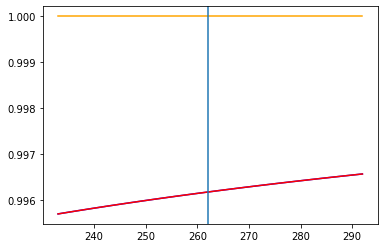

In [491]:
pad = 30
plt.plot(range(end_point-pad,end_point+pad), tensor_far[0,end_point-pad:end_point+pad], 'blue')
plt.plot(range(end_point-pad,end_point+pad), tensor_lar[0,end_point-pad:end_point+pad], 'orange')
#plt.plot(tensor_mar[0,:], 'green')
plt.plot(range(end_point-pad,end_point+pad), tensor_aq[0,end_point-pad:end_point+pad], 'red')
plt.axvline(end_point-1)

In [162]:
aq

tensor([0.8860])

In [190]:
alignments.size()

torch.Size([1, 656, 67])

In [143]:
np_end_point = int(end_points[0] / alignments.size(1) * np_audio.shape[0])

In [144]:
ipd.display(ipd.Audio(np_audio[:np_end_point], rate=hparams.sampling_rate))